In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP#,MLP2
from utils.interactions import rollout_traj_env_policy
from models.model_training import ModelTrainer
from models.models import NeuralEulerODE

2024-11-29 16:13:46.520469: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
class NodeInEnvWrapper:
    def __init__(self,node,motor_env):
        self.motor_env=motor_env
        self.node=node
        self.env_properties= motor_env.env_properties
    
    def step(self,state, action,env_properties):
        obs=self.motor_env.generate_observation(state,self.motor_env.env_properties)
        obs2= self.node.step(obs[0:2], action, self.motor_env.tau)
        obs = obs.at[0].set(obs2[0])
        obs = obs.at[1].set(obs2[1])
        state= self.motor_env.generate_state_from_observation(obs,self.motor_env.env_properties)
        return obs ,state
    
    def generate_state_from_observation(self, init_obs, env_properties):
        return self.motor_env.generate_state_from_observation(init_obs,self.motor_env.env_properties)

In [4]:
class EnvInNodeWrapper:
    def __init__(self,motor_env):
        self.motor_env=motor_env
    
    def step(self, obs ,action,tau):
        obs1,_= self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        state=self.motor_env.generate_state_from_observation(obs1,self.motor_env.env_properties)
        obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        return obs[0:2]

In [5]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [6]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

In [7]:
@eqx.filter_jit
def reset(node,rng):
    obs, _ = motor_env.reset(motor_env.env_properties, rng)  #
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

In [8]:
@eqx.filter_jit
def node_dat_gen_sin(node,reset_env, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset_env(node,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset_env(node,subkey)  
    return init_obs, ref_obs, rng

In [9]:
@eqx.filter_jit
def featurize(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])#jnp.concatenate([obs[0:2],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

In [10]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,4:6])**2,axis=1))#be aware of idx if changing featurize
    return loss

In [11]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [12]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2],key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [13]:
data_batch_size=100
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=5000,
    horizon_length=25,
    reset_env=reset,
    data_gen_sin=node_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [14]:
def featurize_node(obs):
    return obs[:2]

In [15]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves("trained_models/Model_100k_100len_100b_step0_0001.eqx", node_struct)

100%|██████████| 5000/5000 [00:54<00:00, 91.87it/s] 


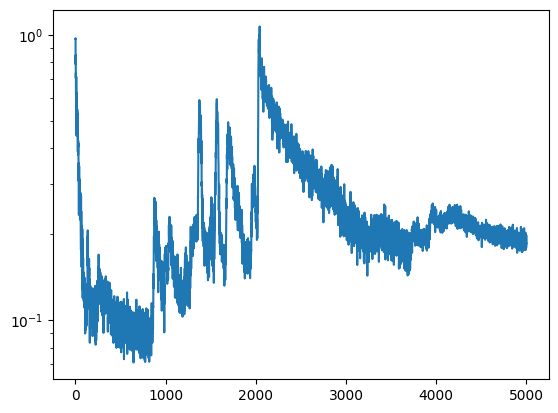

In [16]:
fin_policy_100,fin_opt_state,fin_keys,losses=trainer.fit_on_node_non_jit(policy, node, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

In [17]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves("trained_models/Model_100k_50len_100b_step0_0001.eqx", node_struct)

100%|██████████| 5000/5000 [00:46<00:00, 107.38it/s]


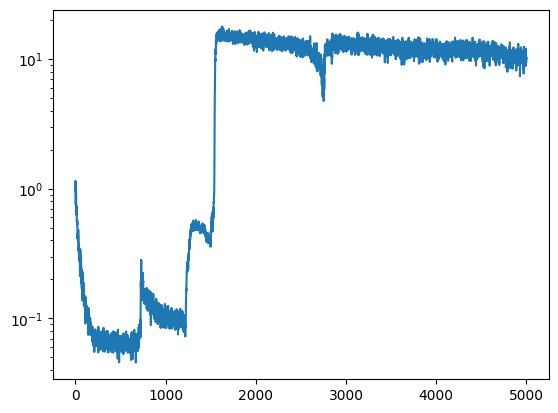

In [18]:
fin_policy_50,fin_opt_state,fin_keys,losses=trainer.fit_on_node_non_jit(policy, node, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

In [17]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves("trained_models/Model_100k_1len_100b_step0_0001.eqx", node_struct)

100%|██████████| 5000/5000 [00:46<00:00, 106.68it/s]


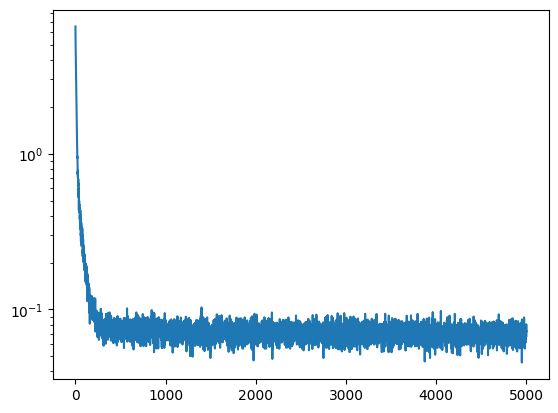

In [18]:
fin_policy_1,fin_opt_state,fin_keys,losses=trainer.fit_on_node_non_jit(policy, node, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:36<00:00, 31.86it/s]


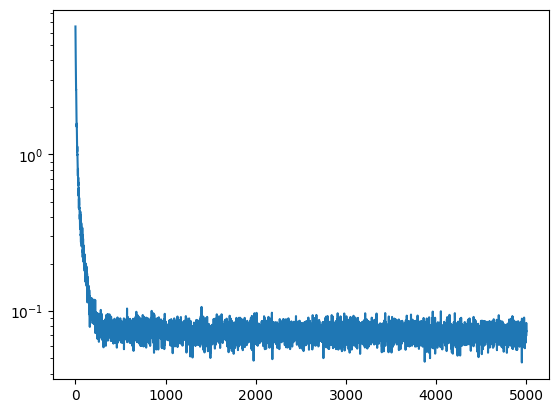

In [19]:
fin_policy_env,fin_opt_state2,fin_keys2,losses2=trainer.fit_non_jit(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

In [20]:
from utils.evaluation import steps_eval

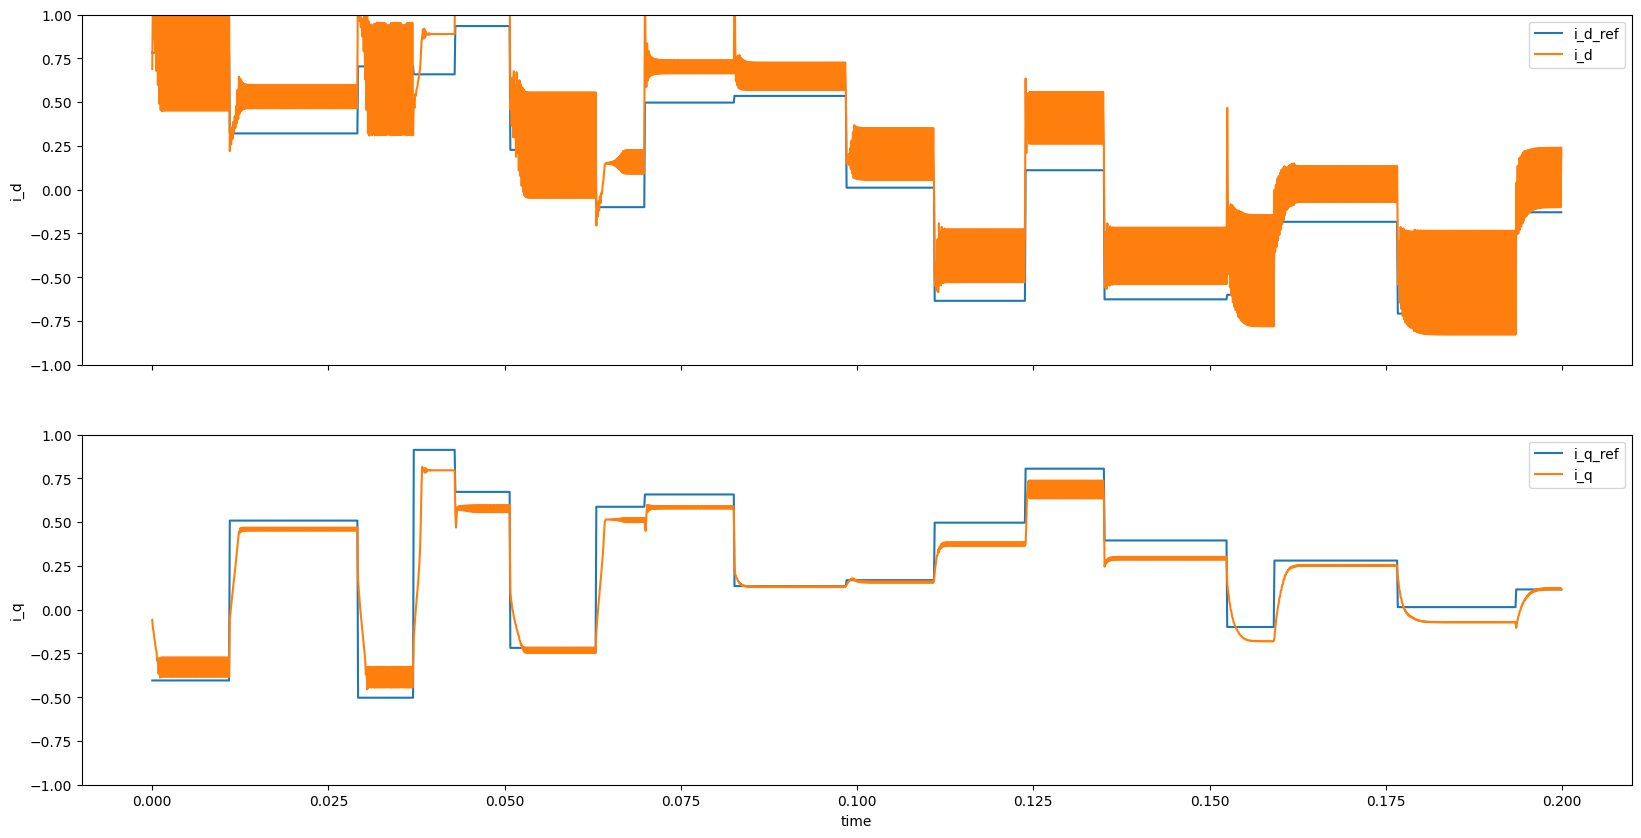

In [21]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_100,featurize,jax.random.PRNGKey(2),2000)

In [22]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_50,featurize,jax.random.PRNGKey(2),2000)

NameError: name 'fin_policy_50' is not defined

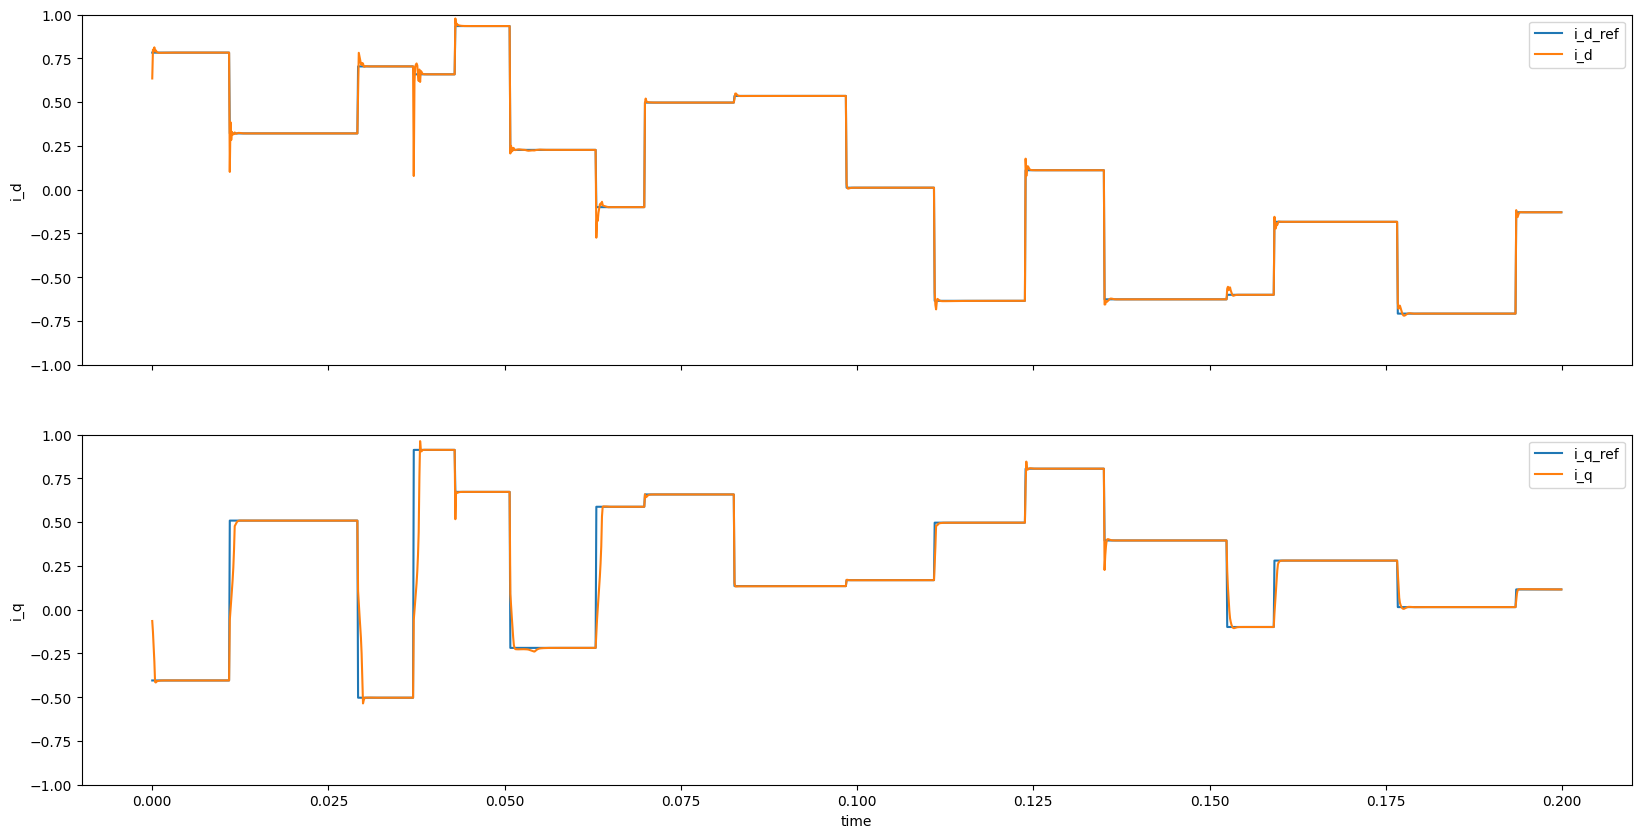

In [23]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_1,featurize,jax.random.PRNGKey(2),2000)

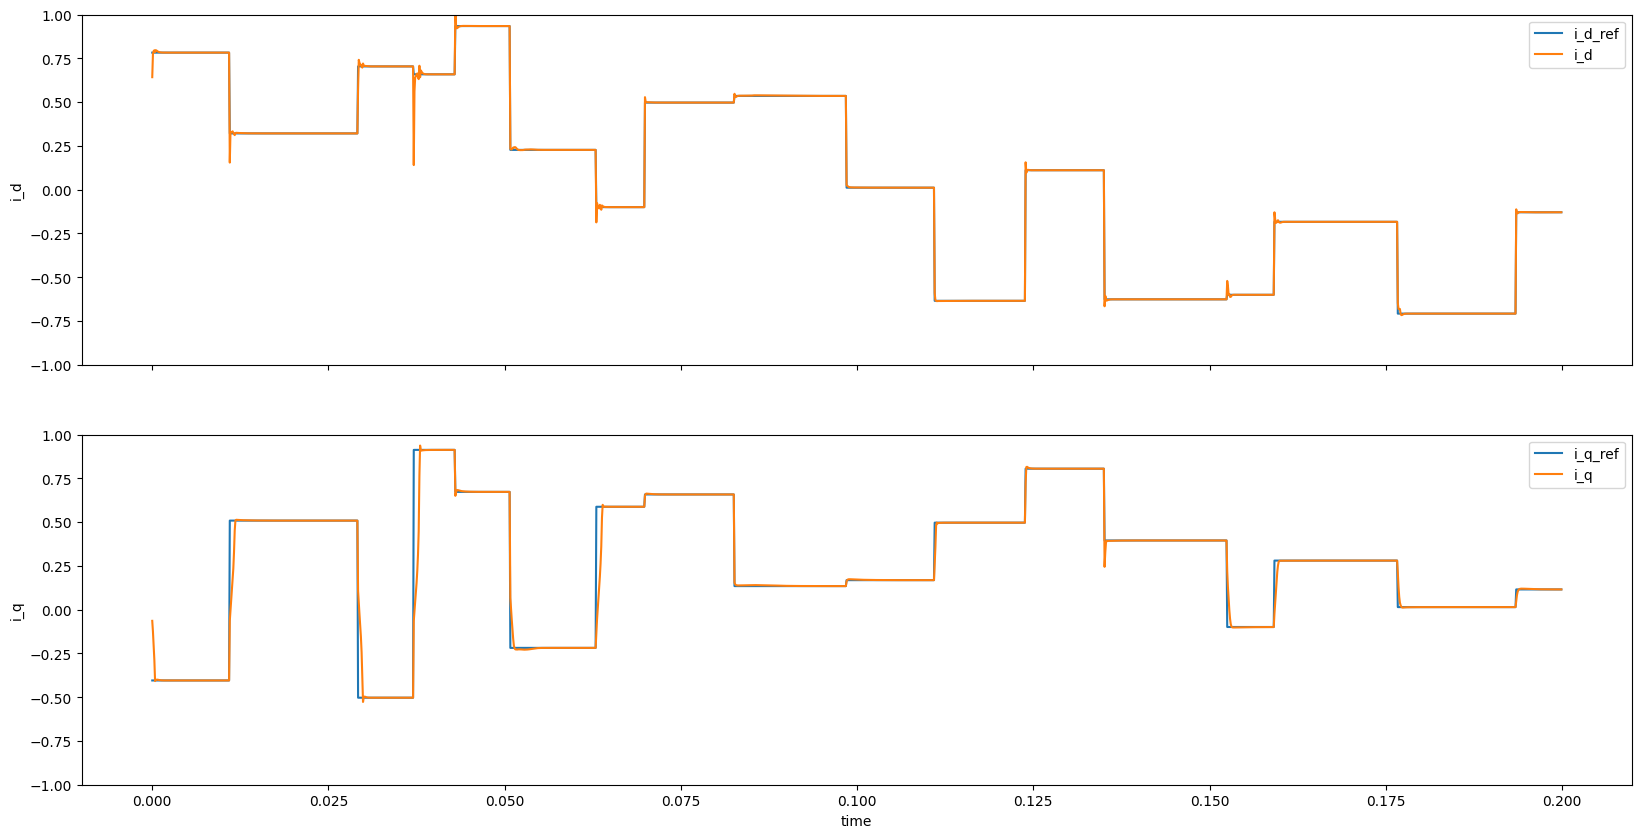

In [24]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_env,featurize,jax.random.PRNGKey(2),2000)

In [ ]:
@eqx.filter_jit
def featurize_nint(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])#jnp.concatenate([obs[0:2],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    #featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

In [28]:
data_batch_size=100
trainer_nint=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=5000,
    horizon_length=25,
    reset_env=reset,
    data_gen_sin=node_dat_gen_sin,
    featurize=featurize_nint,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [29]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves("trained_models/Model_100k_1len_100b_step0_0001.eqx", node_struct)

100%|██████████| 5000/5000 [00:45<00:00, 109.93it/s]


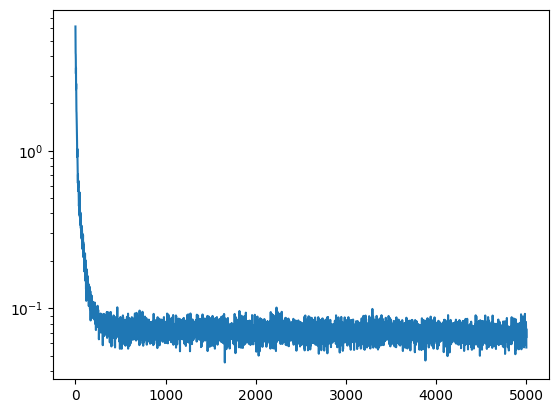

In [30]:
fin_policy_1_nint,fin_opt_state,fin_keys,losses=trainer_nint.fit_on_node_non_jit(policy, node, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

100%|██████████| 5000/5000 [02:25<00:00, 34.38it/s]


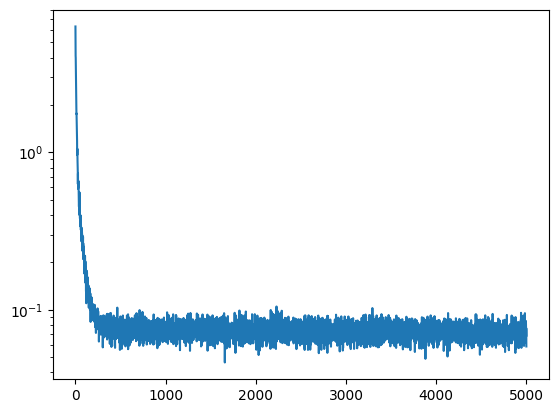

In [31]:
fin_policy_env_nint,fin_opt_state2,fin_keys2,losses2=trainer_nint.fit_non_jit(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

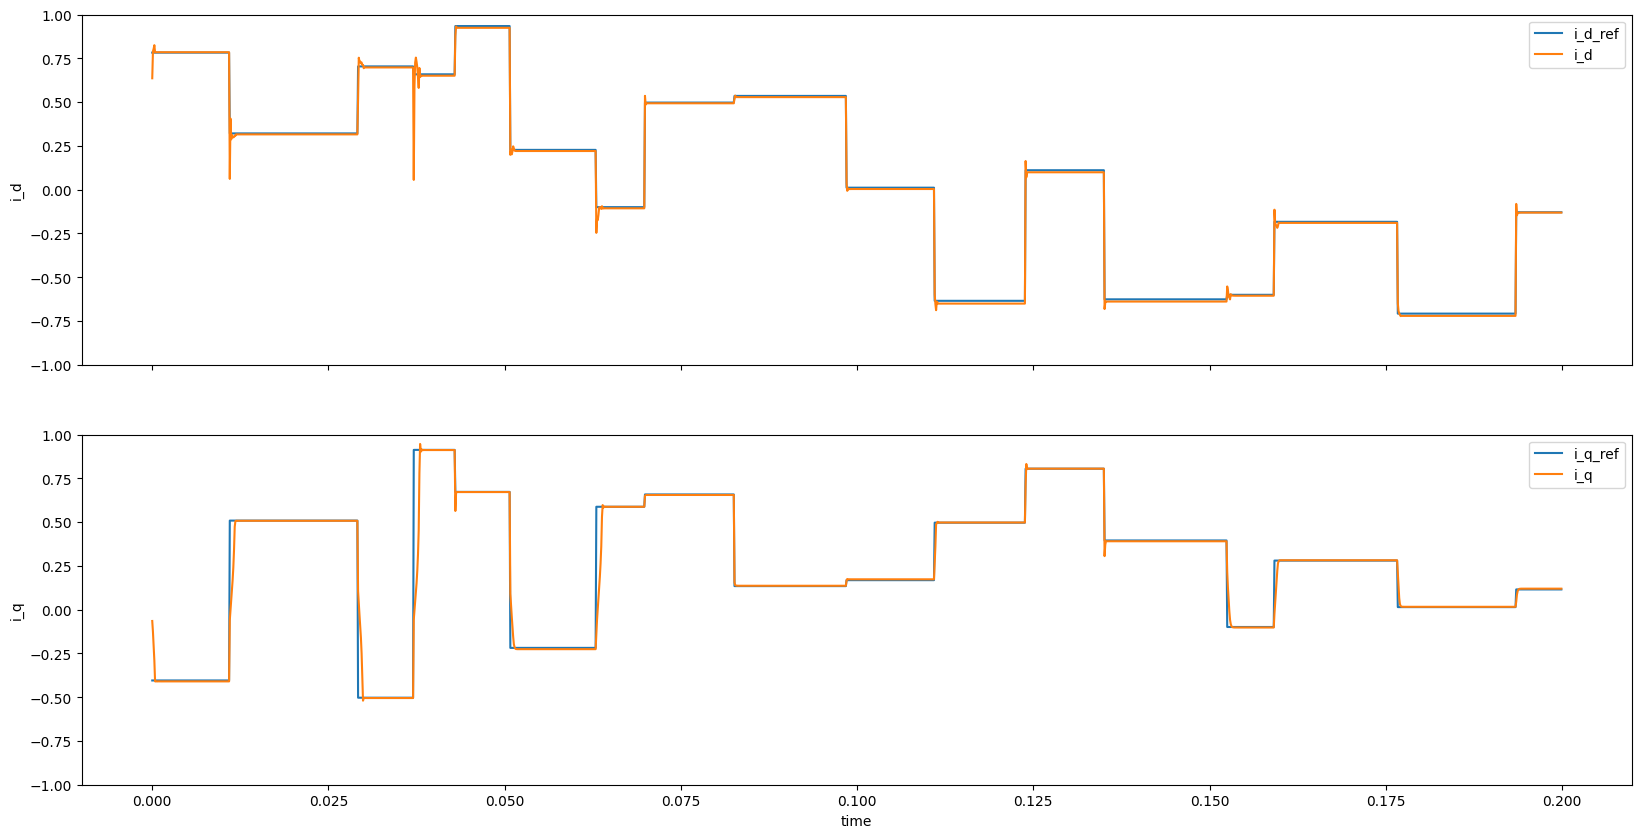

In [33]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_1_nint,featurize_nint,jax.random.PRNGKey(2),2000)

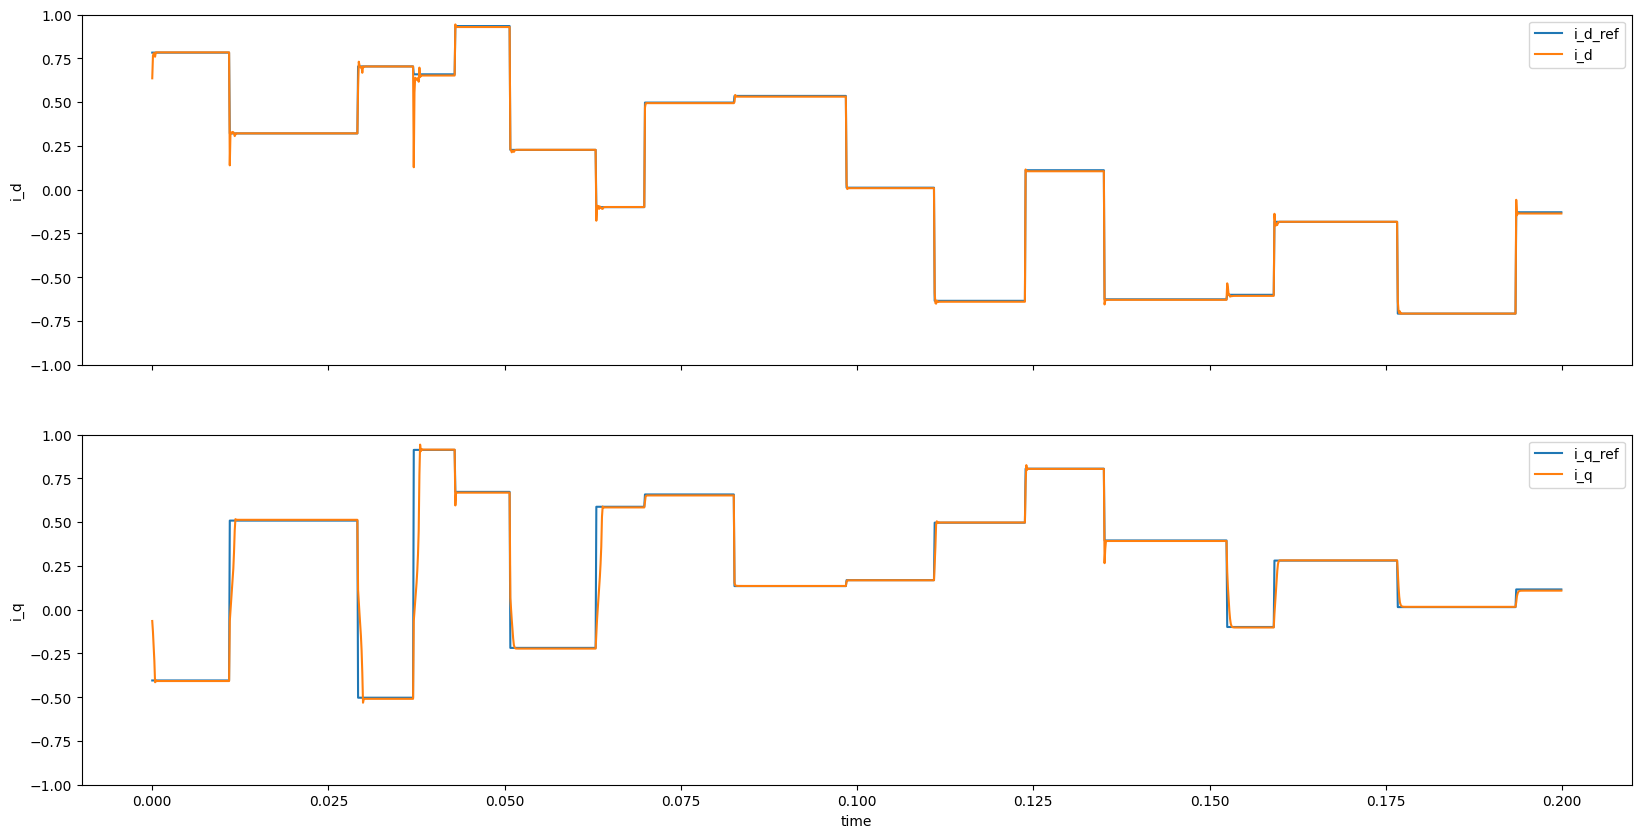

In [34]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_env_nint,featurize_nint,jax.random.PRNGKey(2),2000)